The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import mastquery
import grizli
from grizli.pipeline import auto_script
from grizli import utils, fitting, multifit, prep

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [3]:
utils.set_warnings()
print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Mastquery version: ', mastquery.__version__)


 Python version:  3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

 Grizli version:  1.0.dev1427

 Mastquery version:  1.0


In [4]:
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /Users/gbrammer/Research/grizli/Test


## Query the HST archive ##

The `mastquery` module (https://github.com/gbrammer/mastquery) can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.


# (Fri Apr  3 13:56:47 2020)

query.run_query(**{'kwargs': {'proposal_id': [11359], 'instruments': ['WFC3/IR', 'ACS/WFC'], 'filters': ['G102', 'G141']}, 'base_query': {'intentType': ['science'], 'mtFlag': ['False'], 'obs_collection': ['HST']}, 'position_box': True, 'sort_column': ['obs_id', 'filter'], 'rename_columns': {'t_exptime': 'exptime', 'target_name': 'target', 's_region': 'footprint', 's_ra': 'ra', 's_dec': 'dec', 'filters': 'filter'}, 'get_exptime': True, 'box': None})


Parse polygons
Parse    1 (N=1)
Iter #1, N_Patch = 1


 1 j033216m2743 53.07341407653 -27.70899251213

# (Fri Apr  3 13:56:48 2020)

query.run_query(**{'kwargs': {'proposal_id': [11359], 'instruments': ['WFC3/IR', 'WFC3/UVIS', 'ACS/WFC'], 'filters': ['F098M', 'F140W', 'F160W', 'G102', 'G141'], 'target_name': 'WFC3-ERSII-G01'}, 'base_query': {'obs_collection': ['HST'], 'intentType': ['science'], 'mtFlag': ['False']}, 'position_box': True, 'sort_column': ['obs_id', 'filter'], 'rename_columns': {'t_exptime': 'ex

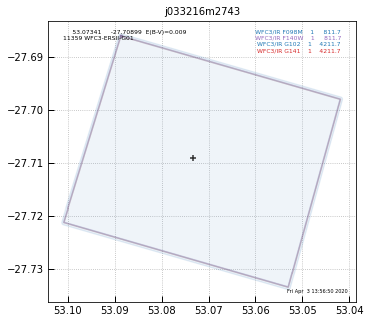

In [5]:
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[11359], 
                         instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F098M', 'F140W', 'F160W','G102', 'G141'], 
                              proposal_id=[11359], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], 
                              extra={'target_name':'WFC3-ERSII-G01'}, close=False)

In [6]:
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  ['j033216m2743_footprint.fits']

# id            ra         dec        e(b-v)   filters
j033216m2743  53.07341  -27.70899   0.0095   F098M,F140W,G102,G141


In [7]:
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /Users/gbrammer/Research/grizli/Test


## Working with pipeline parameters ##


Grizli versions `>0.10.0` provide an interface for reading pipeline parameters from a YAML ascii file.  All of the parameter defaults are stored in a file in the repository `grizli/data/auto_script_defaults.yml`.  You can edit copies of this file to generate a reproducible history of the pipeline processing.

In [8]:
from grizli.pipeline.auto_script import get_yml_parameters

# Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()
print(list(kwargs.keys()))

['filters', 'fetch_files_args', 'inspect_ramps', 'is_dash', 'run_parse_visits', 'is_parallel_field', 'parse_visits_args', 'manual_alignment', 'manual_alignment_args', 'preprocess_args', 'visit_prep_args', 'redo_persistence_mask', 'persistence_args', 'run_fine_alignment', 'fine_backup', 'fine_alignment_args', 'make_mosaics', 'mosaic_args', 'mask_spikes', 'make_phot', 'multiband_catalog_args', 'only_preprocess', 'overwrite_fit_params', 'grism_prep_args', 'refine_with_fits', 'run_extractions', 'include_photometry_in_fit', 'make_thumbnails', 'thumb_rgb_params', 'drizzler_args', 'thumbnail_args', 'extract_args', 'extract_maglim', 'run_fit']


In [9]:
# Copy default parameters to working directory
default_kwargs = get_yml_parameters(local_file='my_params.yml', copy_defaults=True)

print('\n ---- my_params.yml ---\n')
!head -13 my_params.yml
print('    ...')

Copied default parameter file to my_params.yml

 ---- my_params.yml ---

# Full Grizli pipeline arguments

filters: &filters 
    [F410M, F467M, F547M, F550M, F621M, F689M, F763M, F845M, F200LP, F350LP,
     F435W, F438W, F439W, F450W, F475W, F475X, F555W, F569W, F600LP, F606W,
     F622W, F625W, F675W, F702W, F775W, F791W, F814W, F850LP, G800L, F098M,
     F127M, F139M, F153M, F105W, F110W, F125W, F140W, F160W, G102, G141]

# Arguments to grizli.pipeline.fetch_files
fetch_files_args: 
    reprocess_parallel: False 
    reprocess_clean_darks: True
    remove_bad: True
    ...


In [10]:
# Perhaps edit the parameter file by hand, then read it in.
# Or just edit the "default_kwargs" dictionary directly and pass that
kwargs = get_yml_parameters(local_file='my_params.yml', copy_defaults=False)

# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [11]:
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

try:
    root = tabs[0].meta['NAME']
    print('root: {0}'.format(root))
except:
    root = 'j033216m2743'

IS_PARALLEL = False # Set to True for parallel programs like WISPS
kwargs['is_parallel_field'] = IS_PARALLEL

if False:
    # This line would do everything below up to extracting spectra
    auto_script.go(root=root, HOME_PATH=HOME_PATH, **kwargs)

HOME_PATH =  /Users/gbrammer/Research/grizli/Test
root: j033216m2743


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [12]:
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)
 
s3_sync = kwargs['fetch_files_args']['s3_sync']
if s3_sync:
    print('Get HST files from AWS/S3 with awscli')
else:
    print('Get HST files from ESA archive')

# Use multiprocessing for calwf3
kwargs['fetch_files_args']['reprocess_parallel'] = True

# Don't remove drk calibration files for now to avoid re-downloading them
kwargs['fetch_files_args']['reprocess_clean_darks'] = False 

auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, **kwargs['fetch_files_args'])

Get HST files from AWS/S3 with awscli
# (Fri Apr  3 13:56:53 2020)

auto_script.fetch_files(**{'min_bad_expflag': 2, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141'], 'fetch_flt_calibs': ['IDCTAB', 'PFLTFILE', 'NPOLFILE'], 's3_sync': 'cp', 'reprocess_clean_darks': False, 'reprocess_parallel': True, 'remove_bad': True, 'inst_products': {'ACS/WFC': ['FLC'], 'WFC3/IR': ['RAW'], 'WFC3/UVIS': ['FLC'], 'WFPC2/PC': ['C0M', 'C1M'], 'WFPC2/WFC': ['C0M', 'C1M']}, 'HOME_PATH': '/Users/gbrammer/Research/grizli/Test', 'field_root': 'j033216m2743'})

Fetch 16 files (s3_sync=cp)
Calib: IDCTAB=iref$w3m18525i_idc.fits
/Users/gbrammer/Research/grizli/iref/w3m18525i_idc.fits exists
Cal

## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [13]:
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
kwargs['parse_visits_args']['combine_same_pa'] = True
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, 
                                                    **kwargs['parse_visits_args'])

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

# (Fri Apr  3 13:57:49 2020)

auto_script.parse_visits(**{'max_dt': 0.5, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141'], 'is_dash': False, 'combine_minexp': 2, 'combine_same_pa': True, 'use_visit': True, 'HOME_PATH': '/Users/gbrammer/Research/grizli/Test', 'field_root': 'j033216m2743'})

WFC3-ERSII-G01-b6o-21-119.0-F098M 4
WFC3-ERSII-G01-b6o-23-119.0-F140W 4
WFC3-ERSII-G01-b6o-21-119.0-G102 4
WFC3-ERSII-G01-b6o-23-119.0-G141 4
# (Fri Apr  3 13:57:49 2020)
parse_visits(combine_same_pa=True), max_dt=0.5: BEFORE   4 visits
# (Fri Apr  3 13:57:50 2020)
parse_visits(combine_same_pa=True), max_dt=0.5:  AFTER   4 visits
** Combine same PA: **
0 ib6o-119.0-f098m 4
1 ib6o-1

In [14]:
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
kwargs['parse_visits_args']['combine_same_pa'] = IS_PARALLEL
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, 
                                                    **kwargs['parse_visits_args'])

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

# (Fri Apr  3 13:57:50 2020)

auto_script.parse_visits(**{'max_dt': 0.5, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141'], 'is_dash': False, 'combine_minexp': 2, 'combine_same_pa': False, 'use_visit': True, 'HOME_PATH': '/Users/gbrammer/Research/grizli/Test', 'field_root': 'j033216m2743'})

WFC3-ERSII-G01-b6o-21-119.0-F098M 4
WFC3-ERSII-G01-b6o-23-119.0-F140W 4
WFC3-ERSII-G01-b6o-21-119.0-G102 4
WFC3-ERSII-G01-b6o-23-119.0-G141 4

 == Grism groups ==

wfc3-ersii-g01-b6o-21-119.0-f098m 4 wfc3-ersii-g01-b6o-21-119.0-g102 4
wfc3-ersii-g01-b6o-23-119.0-f140w 4 wfc3-ersii-g01-b6o-23-119.0-g141 4


wfc3-ersii-g01-b6o-21-119.0-f098m  4
wfc3-ersii-g01-b6o-23-119.0-f140w  4
w

## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [15]:
# Parameter lists
visit_prep_args = kwargs['visit_prep_args']
preprocess_args = kwargs['preprocess_args']

# Maximum shift for "tweakshifts" relative alignment
tweak_max_dist = (5 if IS_PARALLEL else 1)
if 'tweak_max_dist' not in visit_prep_args:
    visit_prep_args['tweak_max_dist'] = tweak_max_dist

# Fit and subtract a SExtractor-like background to each visit
visit_prep_args['imaging_bkg_params']  = {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 
                                          'pixel_scale': 0.1, 'get_median': False}

# Alignment reference catalogs, searched in this order
preprocess_args['catalogs'] = ['PS1','GAIA','SDSS','WISE']

In [16]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH,
                       visit_prep_args=visit_prep_args, **preprocess_args)    

# (Fri Apr  3 13:57:50 2020)

auto_script.preprocess(**{'persistence_args': {'dq_value': 1024, 'err_threshold': 0.5, 'grow_mask': 3, 'verbose': True, 'reset': False}, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 24, 0.05], 'max_err_percentile': 99, 'catalog_mask_pad': 0.05, 'match_catalog_density': 'None', 'drizzle_params': {}, 'single_image_CRs': True, 'run_tweak_align': True, 'tweak_threshold': 1.5, 'tweak_fit_order': -1, 'tweak_max_dist': 100, 'tweak_n_min': 10, 'align_simple': False, 'align_clip': 120, 'column_average': True, 'sky_iter': 10, 'iter_atol': 0.0001, 'imaging_bkg_params': {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 'pixel_scale': 0.1, 'get_median': False}, 'fix_stars': True, 'reference_catalogs': ['PS1', 'DES', 'DSC', 'SDSS', 'GAIA', 'WISE'], 'outlier_threshold': 4}, 'skip_single_optical_visits': False, 'clean': True, 'skip_imaging': False, 'use_first_radec': False, 'parent_radec': None, 'master_radec': None, 'use_visit': True, '

In [17]:
!ls wfc3*sci.fits # individual drizzled visits

wfc3-ersii-g01-b6o-21-119.0-f098m_drz_sci.fits
wfc3-ersii-g01-b6o-21-119.0-g102_drz_sci.fits
wfc3-ersii-g01-b6o-23-119.0-f140w_drz_sci.fits
wfc3-ersii-g01-b6o-23-119.0-g141_drz_sci.fits


In [18]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

wfc3-ersii-g01-b6o-21-119.0-f098m_shifts.log
wfc3-ersii-g01-b6o-23-119.0-f140w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ib6o21qnq_flt.fits'] = ['ib6o21qmq_flt.fits']
# match['ib6o21qqq_flt.fits'] = ['ib6o21qoq_flt.fits']
# match['ib6o21r7q_flt.fits'] = ['ib6o21r6q_flt.fits']
# match['ib6o21raq_flt.fits'] = ['ib6o21r8q_flt.fits']
ib6o21qnq_flt.fits   0.000   0.000  0.00000  1.00000    69  0.000  0.000
ib6o21qqq_flt.fits   0.066   0.067  0.00000  1.00000    39  0.089  0.078
ib6o21r7q_flt.fits   0.200   0.264  0.00000  1.00000    40  0.102  0.068
ib6o21raq_flt.fits   0.127   0.429  0.00000  1.00000    40  0.076  0.071
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ib6o23rtq_flt.fits'] = ['ib6o23rsq_flt.fits']
# match['ib6o23rwq_flt.fits'] = ['ib6o23ruq_flt.fits']
# match['ib6o23rzq_flt.fits'] = ['ib6o23ryq_flt.fits']
# match['ib6o23s2q_flt.fits'] = ['ib6o23s0q_flt.fits']
ib6o23rtq_flt.fits   0.000   0.000  0.00000  1.00000   100  0

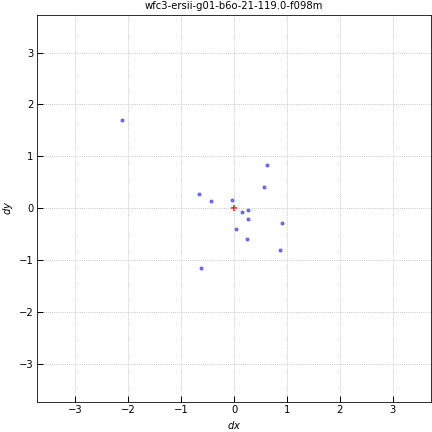

In [19]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.png") 

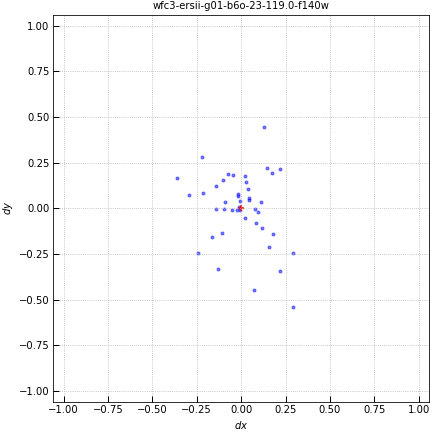

In [20]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.png") 

In [21]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to PS1, with RMS~0.4 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS ~ 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.log: 0 -3.7548 0.0009 -0.0264 0.99944 0.532 14
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.log: 0 -3.7041 0.1976 -0.0218 0.99954 0.151 43


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [22]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

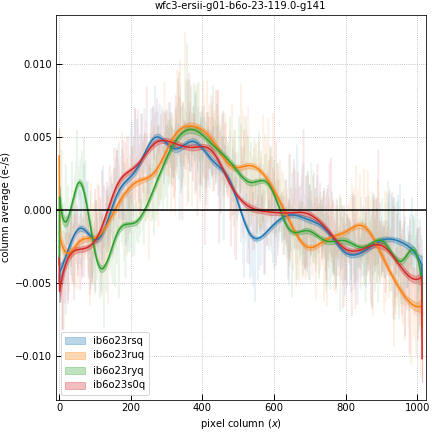

In [23]:
from IPython.display import Image
Image(filename = "./wfc3-ersii-g01-b6o-23-119.0-g141_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [24]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2

if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_alignment_args = kwargs['fine_alignment_args']
    
    # Align to GAIA with proper motions evaluated at 
    # each separate visit execution epoch
    fine_alignment_args['catalogs'] = ['GAIA']
    fine_alignment_args['gaia_by_date'] = True
    
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     **fine_alignment_args)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to directory ./FineBkup
    auto_script.update_wcs_headers_with_fine(root, backup=True)
    
visits, res = np.load('{0}_fine.npy'.format(root), allow_pickle=True)
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

wfc3-ersii-g01-b6o-21-119.0-f098m      0.03   -0.04
wfc3-ersii-g01-b6o-23-119.0-f140w      0.00    0.00


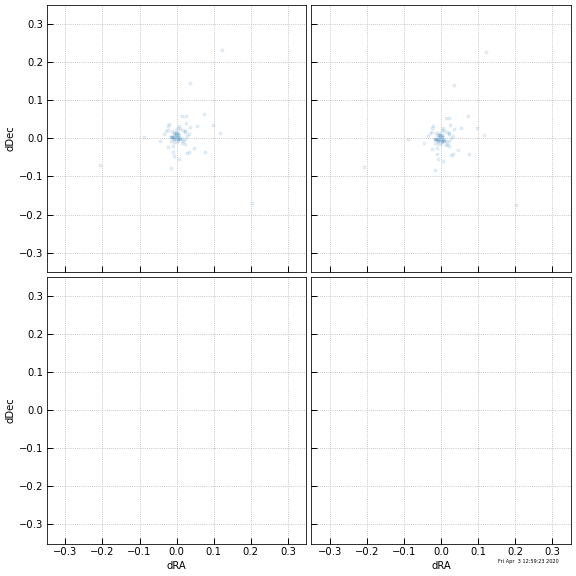

In [25]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

In [26]:
# Update the visits file with the new exposure footprints
print('Update exposure footprints in {0}_visits.npy'.format(root))
res = auto_script.get_visit_exposure_footprints(visit_file='{0}_visits.npy'.format(root),
                              check_paths=['./', '../RAW'])

Update exposure footprints in j033216m2743_visits.npy


## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [27]:
# Drizzle mosaics in each filter and combine all IR filters
mosaic_args = kwargs['mosaic_args']
mosaic_pixfrac = mosaic_args['mosaic_pixfrac']

combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, get_hdu=True, 
                               **mosaic_args['wcs_params'])


    if combine_all_filters:
        all_filters = mosaic_args['ir_filters'] + mosaic_args['optical_filters']
        auto_script.drizzle_overlaps(root, 
                                 filters=all_filters, 
                                 min_nexp=1, pixfrac=mosaic_pixfrac,
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 


    ## IR filters
    if 'fix_stars' in visit_prep_args:
        fix_stars = visit_prep_args['fix_stars']
    else:
        fix_stars = False

    auto_script.drizzle_overlaps(root, filters=mosaic_args['ir_filters'], 
                                 min_nexp=1, pixfrac=mosaic_pixfrac,
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file,
                                 include_saturated=fix_stars) 

    ## Mask diffraction spikes
    mask_spikes=True
    
    ir_mosaics = glob.glob('{0}-f*drz_sci.fits'.format(root))
    if (len(ir_mosaics) > 0) & (mask_spikes):
        cat = prep.make_SEP_catalog('{0}-ir'.format(root), threshold=4, 
                                    save_fits=False, 
                                    column_case=str.lower)

        selection = (cat['mag_auto'] < 17) & (cat['flux_radius'] < 4.5)
        for visit in visits:
            filt = visit['product'].split('-')[-1]
            if filt[:2] in ['f0','f1']:
                auto_script.mask_IR_psf_spikes(visit=visit, selection=selection,
                                   cat=cat, minR=5, dy=5)

        ## Remake mosaics
        auto_script.drizzle_overlaps(root, filters=mosaic_args['ir_filters'], 
                                     min_nexp=1, pixfrac=mosaic_pixfrac,
                                make_combined=(not combine_all_filters),
                                     ref_image=wcs_ref_file,
                                     include_saturated=True) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    fill_mosaics = mosaic_args['fill_mosaics']
    if fill_mosaics:
        if fill_mosaics == 'grism':
            # Only fill mosaics if grism filters exist
            has_grism = utils.column_string_operation(info['FILTER'], 
                                     ['G141','G102','G800L'],
                                     'count', 'or').sum() > 0
            if has_grism:
                auto_script.fill_filter_mosaics(root)                                             
        else:
            auto_script.fill_filter_mosaics(root)


    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))
    wcs_ref_optical = wcs_ref_file
    
    auto_script.drizzle_overlaps(root, 
            filters=mosaic_args['optical_filters'], 
            pixfrac=mosaic_pixfrac,
            make_combined=(len(mosaics) == 0), ref_image=wcs_ref_optical,
            min_nexp=1+preprocess_args['skip_single_optical_visits']*1) 

In [28]:
!ls -1 j03*_dr?_sci.fits

j033216m2743-f098m_drz_sci.fits
j033216m2743-f140w_drz_sci.fits
j033216m2743-ir_drz_sci.fits


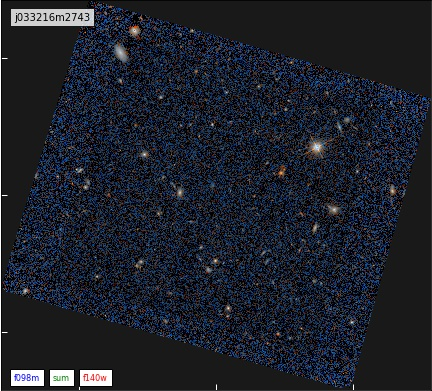

In [29]:
# RGB mosaic
if not os.path.exists('{0}.field.jpg'.format(root)):
    slx, sly, rgb_filts, fig = auto_script.field_rgb(root=root, scl=3, HOME_PATH=None)  
    plt.close(fig)
    
Image(filename='{0}.field.jpg'.format(root)) 

## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [30]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    
    multiband_catalog_args=kwargs['multiband_catalog_args']
    tab = auto_script.multiband_catalog(field_root=root,
                                    **multiband_catalog_args)

#    get_background=False # SExtractor background subtraction

#     tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
#                                         detection_background=get_background,
#                                         photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j033216m2743-ir.cat.fits
j033216m2743-ir_drz_sci.fits
j033216m2743-ir_drz_wht.fits
j033216m2743-ir_bkg.fits
j033216m2743-ir_seg.fits
j033216m2743-ir.npy
j033216m2743_phot.fits

Metadata

VERSION:	1.10.0
MINAREA:	9
CLEAN:	True
DEBCONT:	0.001
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.0
KRONFACT:	2.5
MINKRON:	5.833333333333459
TOTCFILT:	MULTIPLE
TOTCWAVE:	11893.81485
ZP:	25.99031388859241
PLAM:	11893.81485
FNU:	1.458392575e-07
FLAM:	3.76192185e-20
UJY2DN:	6.856449892930582
DRZ_FILE:	j033216m2743-ir_drz_sci.fits
WHT_FILE:	j033216m2743-ir_drz_wht.fits
GET_BACK:	True
ERR_SCALE:	0.5387470126152039
RESCALEW:	False
APERMASK:	True
GAIN:	2000.0
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.333350000000179
ASEC_1:	0.5000009999999999
APER_2:	11.66667000000025
ASEC_2:	0.7000002
APER_3:	16.66667000000036
ASEC_3:	1.0000002
APER_4:	20.00000000000043
ASEC_4:	1.2
APER_5:	25.00000000000054
ASEC_5:	1.5
APER_6:	50.00000000000108
ASEC_6:	3.0
F098M_VERSION:	1.10.0
F098M_ZP:	25.66721605935202
F098M_PLAM:	9

In [31]:
phot[:2].show_in_notebook()

idx,id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,mag_auto,magerr_auto,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,flux_aper_4,fluxerr_aper_4,flag_aper_4,bkg_aper_4,mask_aper_4,flux_aper_5,fluxerr_aper_5,flag_aper_5,bkg_aper_5,mask_aper_5,flux_aper_6,fluxerr_aper_6,flag_aper_6,bkg_aper_6,mask_aper_6,f098m_flux_aper_0,f098m_fluxerr_aper_0,f098m_flag_aper_0,f098m_bkg_aper_0,f098m_mask_aper_0,f098m_flux_aper_1,f098m_fluxerr_aper_1,f098m_flag_aper_1,f098m_bkg_aper_1,f098m_mask_aper_1,f098m_flux_aper_2,f098m_fluxerr_aper_2,f098m_flag_aper_2,f098m_bkg_aper_2,f098m_mask_aper_2,f098m_flux_aper_3,f098m_fluxerr_aper_3,f098m_flag_aper_3,f098m_bkg_aper_3,f098m_mask_aper_3,f098m_flux_aper_4,f098m_fluxerr_aper_4,f098m_flag_aper_4,f098m_bkg_aper_4,f098m_mask_aper_4,f098m_flux_aper_5,f098m_fluxerr_aper_5,f098m_flag_aper_5,f098m_bkg_aper_5,f098m_mask_aper_5,f098m_flux_aper_6,f098m_fluxerr_aper_6,f098m_flag_aper_6,f098m_bkg_aper_6,f098m_mask_aper_6,f098m_tot_corr,f140w_flux_aper_0,f140w_fluxerr_aper_0,f140w_flag_aper_0,f140w_bkg_aper_0,f140w_mask_aper_0,f140w_flux_aper_1,f140w_fluxerr_aper_1,f140w_flag_aper_1,f140w_bkg_aper_1,f140w_mask_aper_1,f140w_flux_aper_2,f140w_fluxerr_aper_2,f140w_flag_aper_2,f140w_bkg_aper_2,f140w_mask_aper_2,f140w_flux_aper_3,f140w_fluxerr_aper_3,f140w_flag_aper_3,f140w_bkg_aper_3,f140w_mask_aper_3,f140w_flux_aper_4,f140w_fluxerr_aper_4,f140w_flag_aper_4,f140w_bkg_aper_4,f140w_mask_aper_4,f140w_flux_aper_5,f140w_fluxerr_aper_5,f140w_flag_aper_5,f140w_bkg_aper_5,f140w_mask_aper_5,f140w_flux_aper_6,f140w_fluxerr_aper_6,f140w_flag_aper_6,f140w_bkg_aper_6,f140w_mask_aper_6,f140w_tot_corr
,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,,,,,,,,deg,deg,deg,deg,uJy,uJy,,uJy,pix,pix,uJy,uJy,uJy,,,,,,,,uJy,uJy,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,uJy,uJy,,uJy,,
0,1,1.0000000150474662e+30,1782,0,0,593,0,2,286.59906233260625,1.0000524615351853,27293.142649561996,0.6227221494362705,0.01591405045337524,0.0,0.0,0.0,165.20635986328125,0.7891274690628052,5.830920031257847e-07,3.6639241443481296e-05,1.6058526039123535,-1.8726769894783502e-06,0.7217115441719314,1.069011278888517,0.000533689224685665,0.0006984698692338033,517,1,517,0,2,287.59906233260625,2.0000524615351853,1,53.11466168996649,-27.75032364006935,53.11466168996649,-27.75032364006935,0.0,0.0,0,inf,0.0,0.0,nan,nan,nan,48,106.90141668465728,48,0.0,0.0,0.0,1.1989199865118996,nan,nan,nan,nan,48,nan,22.640000000000004,nan,nan,48,nan,39.36,nan,nan,48,nan,71.24000000000001,nan,nan,48,nan,133.88000000000002,nan,nan,48,nan,186.44,nan,nan,48,nan,283.12000000000006,nan,nan,48,nan,1056.1200000000008,nan,nan,48,nan,22.640000000000004,nan,nan,48,nan,39.36,nan,nan,48,nan,71.24000000000001,nan,nan,48,nan,133.88000000000002,nan,nan,48,nan,186.44,nan,nan,48,nan,283.12000000000006,nan,nan,48,nan,1056.1200000000008,1.1656232918139953,nan,nan,48,nan,22.640000000000004,nan,nan,48,nan,39.36,nan,nan,48,nan,71.24000000000001,nan,nan,48,nan,133.88000000000002,nan,nan,48,nan,186.44,nan,nan,48,nan,283.12000000000006,nan,nan,48,nan,1056.1200000000008,1.1938928910206958
1,2,1.0000000150474662e+30,1446,0,664,1145,0,2,900.6910718894322,0.9997702142886586,19370.64815881595,0.6227221026295965,0.0540259

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [32]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args = kwargs['grism_prep_args']
    grism_prep_args['gris_ref_filters'] = {'G141': ['F140W', 'F160W'], 
                                           'G102': ['F105W', 'F098M', 'F110W']}
    
    grp = auto_script.grism_prep(field_root=root, **grism_prep_args)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 1.73 sec.


### The final contamination model ###

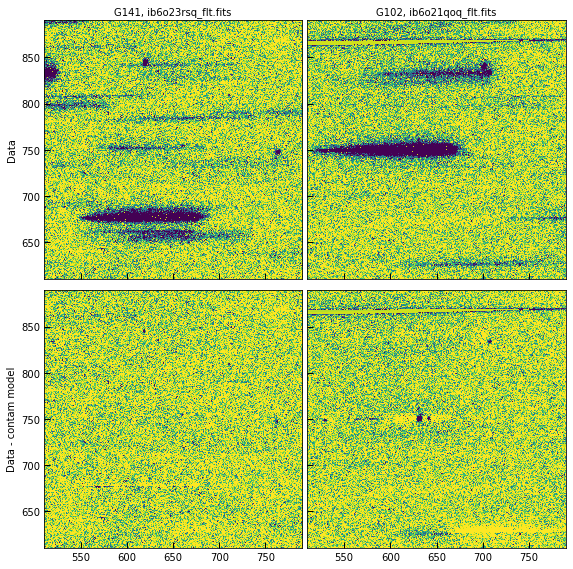

In [33]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [34]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
print(pline) 

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=None, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

{'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
Apply catalog corrections
Compute aperture corrections: i=0, D=0.36" aperture
Compute aperture corrections: i=1, D=0.50" aperture
Compute aperture corrections: i=2, D=0.70" aperture
Compute aperture corrections: i=3, D=1.00" aperture
Compute aperture corrections: i=4, D=1.20" aperture
Compute aperture corrections: i=5, D=1.50" aperture
Compute aperture corrections: i=6, D=3.00" aperture
Apply morphological validity class
Couldn't run morph classification from /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli/data/sep_catalog_junk.pkl
Write j033216m2743_phot_apcorr.fits
/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/eazy/data/templates -> ./templates
/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/s

### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [35]:
# Make PSF file
if not os.path.exists('{0}-f140w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j033216m2743-f098m_psf.fits', 'j033216m2743-f140w_psf.fits'] 

Filename: j033216m2743-f140w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  2  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  3  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


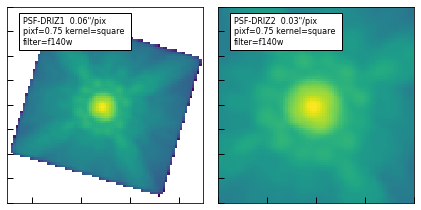

In [36]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f140w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,3])
for i, ext in enumerate([1,2]):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [37]:
os.chdir('../Extractions')

In [38]:
### Find IDs of specific objects to extract
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [53.0657456, 53.0624459]
tab['dec'] = [-27.720518, -27.707018]

idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

idx,ra,dec,id,dr
,deg,deg,,mas
0,53.0657456,-27.720518,152,39.5
1,53.0624459,-27.707018,424,56.3


In [39]:
from importlib import reload
reload(utils)
reload(auto_script)

<module 'grizli.pipeline.auto_script' from '/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli/pipeline/auto_script.py'>

aws_bucket: false
combine_similar_filters: true
filters:
- f160w
- f140w
- f125w
- f105w
- f110w
- f098m
- f850lp
- f814w
- f775w
- f606w
- f475w
- f435w
- f555w
- f600lp
- f390w
- f350lp
half_optical_pixscale: true
include_ir_psf: true
kernel: square
pixfrac: 0.33
pixscale: 0.1
remove: false
rgb_params:
  add_labels: false
  mask_empty: false
  output_dpi: null
  output_format: png
  pl: 1
  rgb_min: -0.01
  scl: 2
  show_ir: false
  suffix: .rgb
  tick_interval: 1
  xsize: 4
scale_ab: 21.5
show_filters:
- visb
- visr
- y
- j
- h
size: 6
subtract_median: true
theta: 0.0
thumb_height: 1.5


##
## RGB thumbnail j033216m2743_00152  (1/2)
##

##
## RGB thumbnail j033216m2743_00424  (2/2)
##


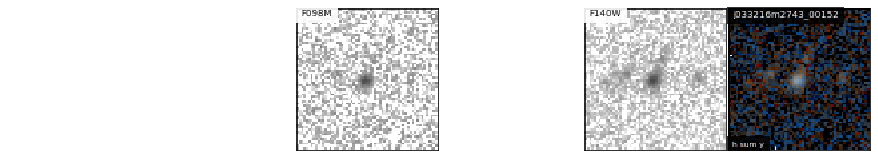

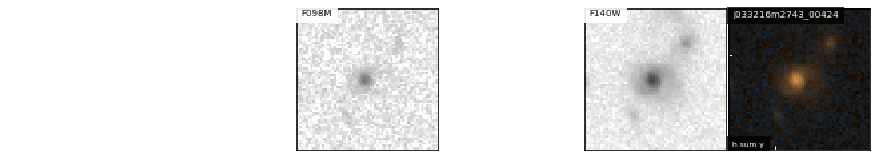

In [40]:
####### Make 2-filter RGB cutouts

# Parameters in drizzler_args
drizzler_args = kwargs['drizzler_args']
print(yaml.dump(drizzler_args))

os.chdir('../Prep')
auto_script.make_rgb_thumbnails(root=root, ids=source_ids, drizzler_args=drizzler_args) #, figsize=[4,4])
os.chdir('../Extractions')
plt.ion()

for id in source_ids:
    # Show the figures
    rgb = plt.imread('../Prep/{0}_{1:05d}.thumb.png'.format(root, id))
    
    fig = plt.figure(figsize=[12, 12*rgb.shape[0]/rgb.shape[1]])
    ax = fig.add_subplot(111)
    ax.imshow(rgb, origin='upper', interpolation='nearest')
    ax.set_axis_off()
    fig.tight_layout(pad=0)
    

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [52]:
id=source_ids[0]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 152 8
j033216m2743_00152.beams.fits


True

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

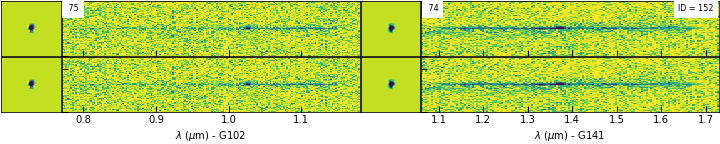

In [42]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

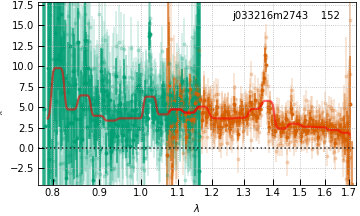

In [43]:
# 1D spectrum with R~30 model
Image(filename='{0}_{1:05d}.R30.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run id=152 with fit_args.npy
j033216m2743_00152.full.fits


(152, 1, 27.882132053375244)

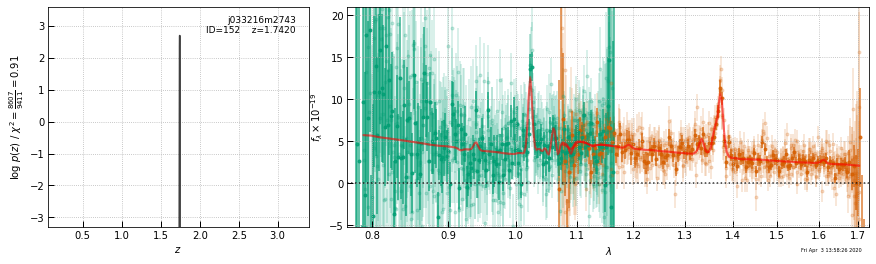

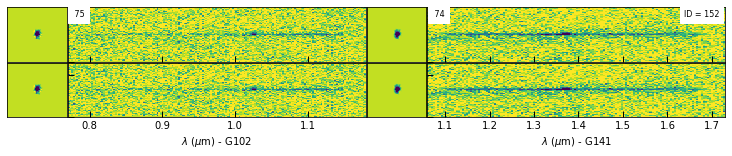

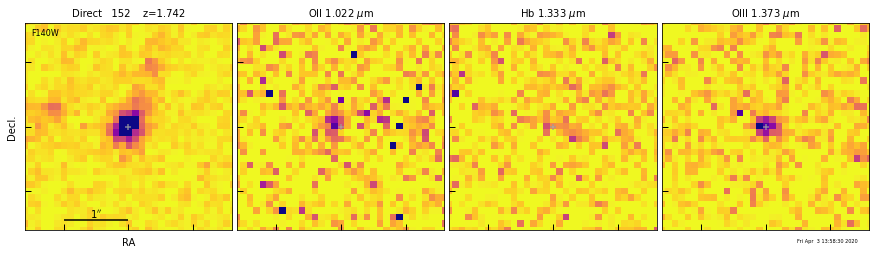

In [44]:
# Fit it.  The "run_all_parallel" function gets parameter defaults set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [45]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j033216m2743_00152.1D.fits
j033216m2743_00152.log_par
j033216m2743_00152.stack.png
j033216m2743_00152.R30.fits
j033216m2743_00152.beams.fits
j033216m2743_00152.R30.png
j033216m2743_00152.full.fits
j033216m2743_00152.stack.fits
j033216m2743_00152.row.fits
j033216m2743_00152.full.png
j033216m2743_00152.line.png


In [46]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j033216m2743_00152.1D.fits


Filename: j033216m2743_00152.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  G141          1 BinTableHDU     41   149R x 8C   [D, D, D, K, D, D, D, D]   
  2  G102          1 BinTableHDU     41   181R x 8C   [D, D, D, K, D, D, D, D]   


j033216m2743_00152.R30.fits


Filename: j033216m2743_00152.R30.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  G141          1 BinTableHDU     41   38R x 8C   [D, D, D, K, D, D, D, D]   
  2  G102          1 BinTableHDU     41   38R x 8C   [D, D, D, K, D, D, D, D]   


j033216m2743_00152.beams.fits


Filename: j033216m2743_00152.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   ()      
  1  REF           1 ImageHDU       244   (64, 64)   float32   
  2  SEG           1 ImageHDU       235   (64, 64)   int32 

 76  DPSF        F160W ImageHDU        25   (80, 80)   float32   


j033216m2743_00152.stack.fits


Filename: j033216m2743_00152.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  SCI         G102,75.0 ImageHDU        54   (178, 64)   float32   
  2  WHT         G102,75.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,75.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,75.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,75.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        53   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   
 10  SCI         G141,74.0 ImageHDU        54   (146, 64)   float32   
 11  WHT         G141,74.0 ImageHDU        22   (146, 64)  

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [47]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

True

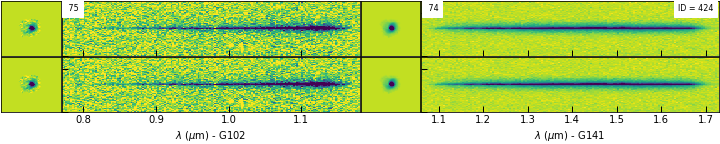

In [48]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

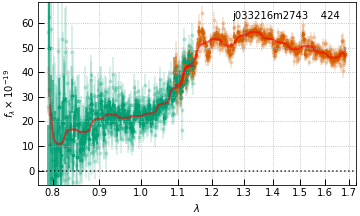

In [49]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.R30.png'.format(root, id)) 

Run id=424 with fit_args.npy
j033216m2743_00424.full.fits


(424, 1, 43.87998986244202)

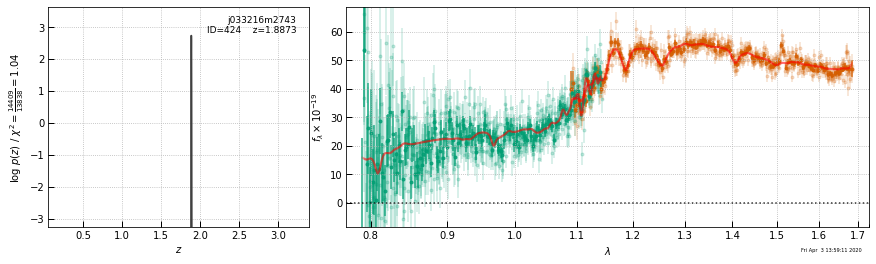

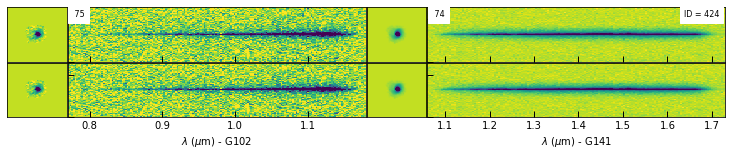

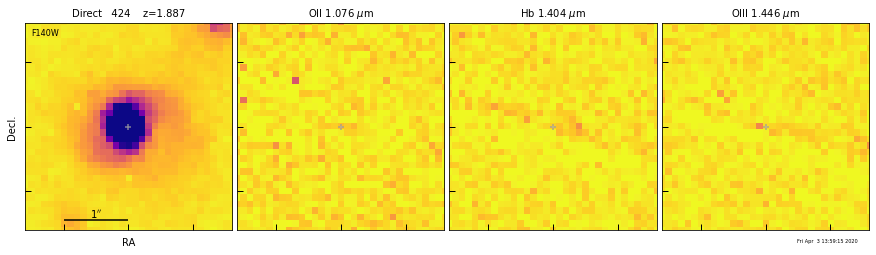

In [50]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).